In [15]:

import numpy as np
import torch
from scipy.integrate import quad
from scipy.special import gammaln
from torch.utils.data import Dataset
import h5py
import pandas as pd

class JetSequenceDataset(Dataset):
    def __init__(
        self,
        filepath: str,
        num_jets: int = None,
        max_seq_length: int = 200,  # dataset max num consituents
        bins: list = [41, 31, 31],
    ):
        self.filepath = filepath
        self.num_jets = num_jets
        self.num_features = len(bins) 
        self.bins = bins
        self.num_bins = int(np.prod(self.bins))
        self.max_seq_length = max_seq_length   

        # special tokens:
        self.start_token = self.num_bins + 1    
        self.end_token = self.num_bins + 2        
        self.pad_token = self.num_bins + 3      

        print(f"INFO: start token: {self.start_token}")
        print(f"INFO: end token: {self.end_token}")
        print(f"INFO: pad token: {self.pad_token}")

        seq = self._sequencize_jetclass()    # shape (N, D)
        self.input_ids = torch.from_numpy(seq).long()
        self.attention_mask = (self.input_ids != self.pad_token).long()
        self.multiplicity = self.attention_mask.sum(axis=1)
        self.end_token_idx = self.multiplicity

        for i in range(self.input_ids.size(0)):
            self.input_ids[i][self.multiplicity[i]] = self.end_token
            self.attention_mask[i][self.multiplicity[i]] = 1

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids":      self.input_ids[idx],      
            "attention_mask": self.attention_mask[idx],
        }

    def _sequencize_jetclass(self):

        with h5py.File(self.filepath, "r") as f:
            arr = f['discretized/block0_values']
            data = arr[:] if self.num_jets is None else arr[: self.num_jets]

        df = pd.DataFrame(data)
        x = df.to_numpy(dtype=np.int64)#[:, : self.max_seq_length * self.num_features]
        x = x.reshape(x.shape[0], -1, self.num_features)
        N, D, _ = x.shape

        seq = self._seq_encoding(x)
        start = np.full((N, 1), self.start_token, dtype=np.int64) # start token 
        seq = np.concatenate((start, seq), axis=1) 
        seq[seq < 0] = self.pad_token
        return seq[:, :-1]

    def _seq_encoding(self, x):
        """ encode the 3-D binned jet constituents into a 1-D sequence of tokens 
        """
        tokens = (x[..., 0] * self.bins[1] + x[..., 1]) * self.bins[2] + x[..., 2]
        return tokens
    

In [16]:
jets = JetSequenceDataset(filepath='/home/df630/SyntheticJets/data/ZJetsToNuNu_val___1Mfromeach_403030.h5')


INFO: start token: 39402
INFO: end token: 39403
INFO: pad token: 39404


In [17]:
jets.input_ids.shape, jets.input_ids[0], jets.attention_mask[0], 

(torch.Size([900000, 200]),
 tensor([39402, 32193, 26427, 21622, 21622, 21622, 20660, 19700, 16817, 15856,
         14926, 13934, 12016, 10053,  8075,  6379,  5290,  5374,  4179, 39403,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404, 39404,
         39404, 39404, 3

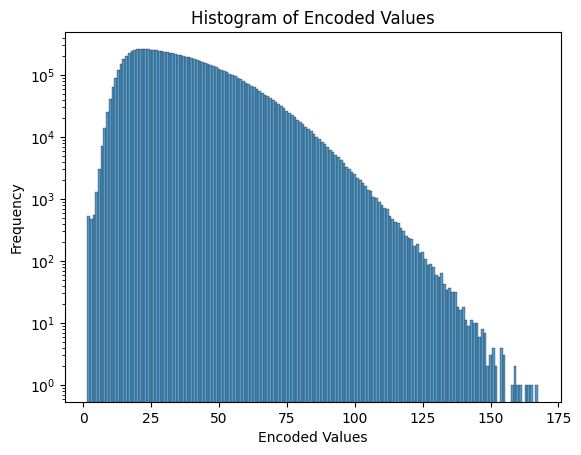

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(jets.multiplicity, discrete=True)

plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.yscale('log')
plt.show()

In [ ]:
dataset = JetSequenceDataset(
    filepath="data/TTBar_val___1Mfromeach_403030.h5",
    num_jets=1000,
    seq_length=200,
    bins=[40,30,30],
)

d0 = dataset[0]
print(d0["input_ids"].shape, d0["attention_mask"].shape)

torch.Size([202]) torch.Size([202])


In [1]:
# 1) Import Comet *before* torch/Lightning to capture all logs
import comet_ml
import numpy as np
import pytorch_lightning as L
from pytorch_lightning.loggers import CometLogger
from torch.utils.data import DataLoader, random_split

from models import JetGPT2Model
from synthetic_data import JetSequenceDataset

# 2) Hyperparameters
tags = ['qcd', 'bins=[41,31,31]', 'pascal2']
seq_length      = 50         # must match model!
bins            = [41, 31, 31]
batch_size      = 100
n_embd          = 128
n_layer         = 4
n_head          = 4
lr              = 1e-3
max_epochs      = 100

# 3) Logger
logger = CometLogger(
    api_key='8ONjCXJ1ogsqG1UxQzKxYn7tz',
    project_name='tokenized-jets',
    workspace='dfaroughy',
    save_dir='/home/df630/SyntheticJets/experiments/results/comet'
)
logger.experiment.add_tags(tags)

train_dataset = JetSequenceDataset(
    filepath="data/TTBar_train___1Mfromeach_403030.h5",
    num_jets=30_000,
    seq_length=seq_length,
    bins=bins,
)

val_dataset = JetSequenceDataset(
    filepath="data/TTBar_val___1Mfromeach_403030.h5",
    num_jets=2_000,
    seq_length=seq_length,
    bins=bins,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

# 5) Model (same seq_length & bins!)
model = JetGPT2Model(
    seq_length=seq_length,
    bins=bins,
    n_embd=n_embd,
    n_layer=n_layer,
    n_head=n_head,
    learning_rate=lr,
)

# 6) Trainer with both loaders
trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator='gpu',
    devices=[0,1,2,3],
    strategy='auto',
    callbacks=[
        L.callbacks.ModelCheckpoint(
            dirpath=None,
            monitor="val_loss",
            filename="best",
            save_top_k=1,
            mode="min",
            save_last=True,
        )
    ],
    logger=logger,
    sync_batchnorm=True,
    gradient_clip_val=1.0,
)

# 7) Fit!
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


CometLogger will be initialized in online mode
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dfaroughy/tokenized-jets/2ac64339e7dd4dd29277d2f4d05ec505

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 2 - CUDA_VISIBLE_DE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : efficient_leopon_5979
COMET INFO:     url                   : https://www.comet.com/dfaroughy/tokenized-jets/2ac64339e7dd4dd29277d2f4d05ec505
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (8.50 KB)
COMET I

NameError: name 'exit' is not defined

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
sig_gpt2.top_k

39402

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import JetGPT2Model

###############################################################################
N = 10000   # num gen jets
tag = 'fine'
signal_id = "eaaf436a61dd45a59abd89ee7ab64832"        # comet run folder
path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/"
###############################################################################

#...Signal

#...load ckpt and generate data from pretrained GPT2

sig_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{signal_id}/checkpoints/best.ckpt")
sig_gpt2.top_k = sig_gpt2.start_token # remove top_k default cut
prompts = torch.full((N, 1), sig_gpt2.start_token, dtype=torch.long, device=sig_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)


generator = L.Trainer(accelerator="gpu", devices=[0])
sig_gen_seq = generator.predict(sig_gpt2, dataloaders=prompt_dataloadeer)
sig_gen_seq = torch.cat(sig_gen_seq, dim=0)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (52). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 51 but got size 52 for tensor number 3 in the list.

In [14]:
sig_gen_seq[0]

tensor([[31233, 23545, 23266,  ..., 39401, 39401, 39401],
        [24533, 23550, 23572,  ...,  9127,  9581, 39403],
        [23601, 22651, 23419,  ...,  9036,  9005, 39403],
        ...,
        [30370, 23513, 20630,  ..., 39401, 39401, 39401],
        [28412, 25559, 24381,  ...,  5444,  4232, 39403],
        [24464, 23579, 23610,  ...,  9122,  9096, 39403]])

In [15]:
sig_gen_seq[3]

tensor([[27387, 25466, 25466,  ..., 39401, 39401, 39401],
        [32254, 24354, 23605,  ...,  6131, 39403, 39401],
        [28353, 28348, 28348,  ..., 39401, 39401, 39401],
        ...,
        [25500, 23569, 22616,  ...,  8265, 39403, 39401],
        [29250, 26366, 26394,  ..., 39401, 39401, 39401],
        [29278, 27356, 25465,  ..., 39401, 39401, 39401]])

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
import comet_ml
import numpy as np
import pytorch_lightning as L
from pytorch_lightning.loggers import CometLogger
from torch.utils.data import DataLoader, random_split

from models import JetGPT2Model
from synthetic_data import JetSequenceDataset

# 1) Load your trained model
# Replace this path with wherever your .ckpt was saved
ckpt_path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/eaaf436a61dd45a59abd89ee7ab64832/checkpoints/best.ckpt"
model = JetGPT2Model.load_from_checkpoint(ckpt_path)

# make sure it’s in eval mode & on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 2) Prepare a “prompt” dataset of pure BOS tokens
# We’ll generate `n_samples` jets in batches of size `batch_size`
n_samples  = 1000
batch_size = 64
seq_len    = model.seq_length + 2  # includes BOS & room for EOS

# Create a tensor full of PAD IDs, then overwrite [*,0] with BOS
bos_id = model.bos_id
pad_id = model.pad_id
prompts = torch.full((n_samples, seq_len), pad_id, dtype=torch.long)
prompts[:, 0] = bos_id

# Attention mask: 1 for BOS, 0 everywhere else
attention = (prompts != pad_id).long()

prompt_ds = TensorDataset(prompts, attention)
prompt_loader = DataLoader(prompt_ds, batch_size=batch_size)

# 3) Use a Trainer to run `predict`
trainer = Trainer(accelerator="gpu", devices=[0])
predictions = trainer.predict(model, dataloaders=prompt_loader)

# flatten
flat = [seq for batch in predictions for seq in batch]

# (a) if variable lengths are fine:
# flat is your final result

# (b) if you need a tensor:
from torch.nn.utils.rnn import pad_sequence
pad_id = model.pad_id
final_tensor = pad_sequence(flat, batch_first=True, padding_value=pad_id)

# decode back to (a,b,c)
import numpy as np
ids = final_tensor.cpu().numpy()
B, C = model.bins[1], model.bins[2]
a = ids // (B*C)
rem = ids % (B*C)
b = rem // C
c = rem % C

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

In [3]:
flat

[tensor([39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401,
         39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401,
         39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401,
         39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401,
         39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401,
         39401, 27480, 25558, 24597, 23328, 22676, 20478, 19517, 18832, 18555,
         17594, 17839, 17839, 16879, 16907, 15948, 14986, 14681, 13750, 14026,
         13996, 13064, 13035, 13064, 12073, 12075, 12075, 11113, 11141, 11113,
         10929, 10929, 11142,  9937, 10182, 10120, 10149, 10184,  9222,  9222,
          9253,  8291,  8045,  8261,  7298,  7298,  7298,  7299,  7114,  6308,
          6277]),
 tensor([39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401,
         39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401, 39401,
         39401, 39401, 39401, 3940

In [ ]:
import numpy as np

# Example data:
# x[...,0] in 0..40, x[...,1] in 0..30, x[...,2] in 0..30
N, D = 5, 4
x = np.stack([
    np.random.randint(0, 41, size=(N, D)),
    np.random.randint(0, 31, size=(N, D)),
    np.random.randint(0, 31, size=(N, D))
], axis=-1)

# Radix sizes
B = 31  # size for the second coordinate
C = 31  # size for the third coordinate

def pack_triplets(x, B=31, C=31):
    """
    x: np.ndarray of shape (...,3) with ranges
       x[...,0] ∈ [0,40], x[...,1] ∈ [0,30], x[...,2] ∈ [0,30]
    returns: np.ndarray of shape (...) with ids in [0, 41*31*31 - 1]
    """
    return (x[..., 0] * B + x[..., 1]) * C + x[..., 2]

def unpack_ids(ids, B=31, C=31):
    """
    ids: np.ndarray of shape (...) with packed ids
    returns: tuple of 3 arrays (a,b,c) each with shape (...)
    """
    a = ids // (B * C)
    rem = ids % (B * C)
    b = rem // C
    c = rem % C
    return a, b, c

# Pack:
ids = pack_triplets(x, B, C)
print("Packed IDs shape:", ids.shape)

# Unpack:
a, b, c = unpack_ids(ids, B, C)
# Re-stack to compare with original x:
x_recon = np.stack([a, b, c], axis=-1)

# Verify bijection:
assert np.array_equal(x, x_recon), "Unpacked values do not match original!"
print("Pack/unpack verified!")


Packed IDs shape: (5, 4)
Pack/unpack verified!


In [ ]:
ids

array([[ 7196, 22976, 19173,  7258],
       [38356, 35175, 35856, 26241],
       [23762,   434, 24791,  6210],
       [19177, 27449, 25243,  5736],
       [33035, 36221, 19682, 15638]])

# Permutation-invariant model

In [ ]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gammaln
from scipy.optimize import minimize_scalar
import math
from numpy.polynomial.laguerre import laggauss

class TokenizedJetClass:
    def __init__(
        self,
        shape_param=1.0,   # k hyper-param in Gamma(beta|k) prior
        scale_param=1.0,   # Sigma hyper-param in N(phi|0,Sigma) prior
        tokenize=False,    # True: tokenized constituents
        z_order=False,     # True: canonically ordered
        bins_z=None,       # bins for tokenization
        bins_phi=None,     # bins for tokenization
    ):
        self.shape = shape_param
        self.scale = scale_param
        self.tokenize = tokenize
        self.z_order = z_order

        if tokenize:
            self.bins_z = bins_z
            self.bins_phi = bins_phi
            self.num_z_bins = len(self.bins_z) - 1

    def sample(self, N, num_constituents=30):
        
        samples = (
            np.zeros((N, num_constituents, 2))
            if not self.tokenize
            else np.zeros((N, num_constituents), dtype=int)
        )

        for i in range(N):
            beta = np.random.gamma(shape=self.shape)   
            event_points = np.zeros((num_constituents, 2))

            for j in range(num_constituents):
                z = np.random.beta(0.5, 1 + beta)
                phi = np.random.normal(loc=self.scale * z - beta, scale=z)
                event_points[j, :] = [z, phi]

            if self.z_order:
                event_points = event_points[np.argsort(event_points[:, 0])][::-1]

            if self.tokenize:
                for j in range(num_constituents):
                    z, phi = event_points[j, :]
                    z_bin = np.digitize(z, self.bins_z) - 1
                    phi_bin = np.digitize(phi, self.bins_phi) - 1
                    z_bin = np.clip(z_bin, 0, len(self.bins_z) - 2)
                    phi_bin = np.clip(phi_bin, 0, len(self.bins_phi) - 2)
                    token = phi_bin * self.num_z_bins + z_bin
                    samples[i, j] = token
            else:
                samples[i, :, 0] = event_points[:, 0]
                samples[i, :, 1] = event_points[:, 1]

        return samples

    def tokens_to_bins(self, tokenized_sample):
        # Compute the individual bin indices.
        z_bin = tokenized_sample % self.num_z_bins
        phi_bin = tokenized_sample // self.num_z_bins
        z_bin = np.clip(z_bin, 0, len(self.bins_z) - 2)
        phi_bin = np.clip(phi_bin, 0, len(self.bins_phi) - 2)
        z_center = (self.bins_z[z_bin] + self.bins_z[z_bin + 1]) / 2
        phi_center = (self.bins_phi[phi_bin] + self.bins_phi[phi_bin + 1]) / 2
        return np.stack((z_center, phi_center), axis=-1)


    def log_probs(self, sample, alpha=0.5):
        return np.array([
            self._log_likelihood(sample[i], alpha)
            for i in range(len(sample))
        ])


    def _log_likelihood(self, sample, alpha=0.5):
        z   = sample[:,0]
        phi = sample[:,1]
        D   = len(z)

        sum_log_z   = np.sum(np.log(z))
        sum_log_1mz = np.sum(np.log(1 - z))
        log_gk      = gammaln(self.shape)

        def log_joint(beta):
            lp_beta = (self.shape-1)*math.log(beta) - beta - log_gk
            A       = gammaln(alpha+1+beta) - gammaln(alpha) - gammaln(1+beta)
            lp_z    = D*A + (alpha-1)*sum_log_z + beta*sum_log_1mz
            quad_c  = -0.5*(D*math.log(2*math.pi) + 2*sum_log_z)
            sq_err  = np.sum(((phi - (self.scale*z - beta))**2)/(z**2))
            lp_phi  = quad_c - 0.5*sq_err
            return lp_beta + lp_z + lp_phi

        # --- Gauss‐Laguerre ---
        n_gl = 50  # try 50 or 100 points
        nodes, weights = laggauss(n_gl)
        # nodes x_i, weights w_i approximate ∫₀∞ e^{-x} g(x) dx ≈ ∑ w_i g(x_i)
        # Here g(β) = exp(log_joint(β) + β)
        g_vals = np.exp([log_joint(b) + b for b in nodes])
        val = np.dot(weights, g_vals)

        if val <= 0 or not np.isfinite(val):
            return -np.inf
        return math.log(val)


In [ ]:
import numpy as np
from scipy.special import gammaln
import math

from synthetic_data_  import SyntheticJets

N_samples = 50000   # Use a moderate number for demonstration (increase if needed)
D = 30
params_qcd = (1, 1)
params_tops = (2, 2)


qcd = SyntheticJets(shape_param=params_qcd[0], 
                    scale_param=params_qcd[1], 
                    )
tops = SyntheticJets(shape_param=params_tops[0], 
                      scale_param=params_tops[1], 
                      )

toy_qcd = qcd.sample(N_samples, num_constituents=D)
toy_tops = tops.sample(N_samples, num_constituents=D)
                
# toy_qcd = generate_point_clouds(N=N_samples, D=D, k=params_qcd[0], Sigma=params_qcd[1])
# toy_tops = generate_point_clouds(N=N_samples, D=D, k=params_tops[0], Sigma=params_tops[1])
# np.save('correlated_toy_qcd_2M.npy', toy_qcd)
# np.save('correlated_toy_tops_2M.npy', toy_tops)


## distribution plots

In [ ]:
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns


# toy_qcd = np.load('data/toy_bkg_data_2M.npy')[:100000]
# toy_tops = np.load('data/toy_sig_data_2M.npy')[:100000]

qcd_x = toy_qcd[:, :, 0].flatten()
qcd_y = toy_qcd[:, :, 1].flatten()
tops_x = toy_tops[:, :, 0].flatten()
tops_y = toy_tops[:, :, 1].flatten()

qcd_x_mean = toy_qcd[:, :, 0].mean(axis=1)
qcd_y_mean = toy_qcd[:, :, 1].mean(axis=1)
tops_x_mean = toy_tops[:, :, 0].mean(axis=1)
tops_y_mean = toy_tops[:, :, 1].mean(axis=1)

qcd_x_std = toy_qcd[:, :, 0].std(axis=1)
qcd_y_std = toy_qcd[:, :, 1].std(axis=1)
tops_x_std = toy_tops[:, :, 0].std(axis=1)
tops_y_std = toy_tops[:, :, 1].std(axis=1)


# --- Create subplots ---
fig, ax = plt.subplots(3, 2, figsize=(4, 4))

# bins=np.linspace(0,1,40)
bins=100
# --- Plot the histograms ---

# Top row: x and y distributions of z and phi.
sns.histplot(qcd_x, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[0, 0])
sns.histplot(tops_x, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[0, 0])

ax[0,0].set_ylabel('Density')
ax[0,0].set_xlabel(r'$z$')
ax[0,0].set_yscale('log')
ax[0,0].legend(loc='upper right', fontsize=6)


sns.histplot(qcd_y, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[0, 1])
sns.histplot(tops_y, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[0, 1])
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel(r'$\varphi$')

bins=100

# Middle row: mean distributions
sns.histplot(qcd_x_mean, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[1, 0])
sns.histplot(tops_x_mean, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 0])
ax[1,0].set_ylabel('Density')
ax[1,0].set_xlabel(r'$\langle z\rangle$')

sns.histplot(qcd_y_mean, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[1, 1])
sns.histplot(tops_y_mean, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 1])
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel(r'$\langle\varphi\rangle$')

# Bottom row: standard deviation distributions
sns.histplot(qcd_x_std, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[2, 0])
sns.histplot(tops_x_std, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 0])
ax[2,0].set_ylabel('Density')
ax[2,0].set_xlabel(r'$\sigma_z$')

sns.histplot(qcd_y_std, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[2, 1])
sns.histplot(tops_y_std, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 1])
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel(r'$\sigma_\varphi$')

custom_ticks = {
    0: [0, 0.2, 0.4, 0.6, 0.8, 1],
    1: [-8, -4, 0, 4, 8],
    2: [0, 0.1, 0.2, 0.3, 0.4, 0.5] ,
    3: [-8, -4, 0, 4, 8],
    4: [0, 0.1, 0.2, 0.3, 0.4],
    5: [0, 1, 2, 3, 4, 5, 6]
}

plt.tight_layout()
fig.subplots_adjust(hspace=0.65, wspace=0.3) 
plt.savefig('synthetic_jets.png', dpi=300, bbox_inches='tight')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'synthetic_data/toy_bkg_data_2M.npy'

In [ ]:
from utils import ordered_z_plots

def canonical_order(samples):
    idx = np.argsort(-samples[:, :, 0], axis=1)
    return np.take_along_axis(samples, idx[:, :, None], axis=1)


toy_qcd_ord = canonical_order(toy_qcd)
toy_tops_ord = canonical_order(toy_tops)


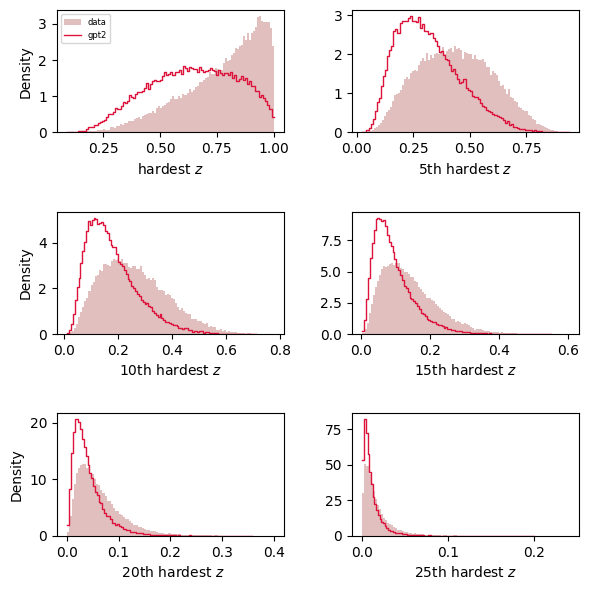

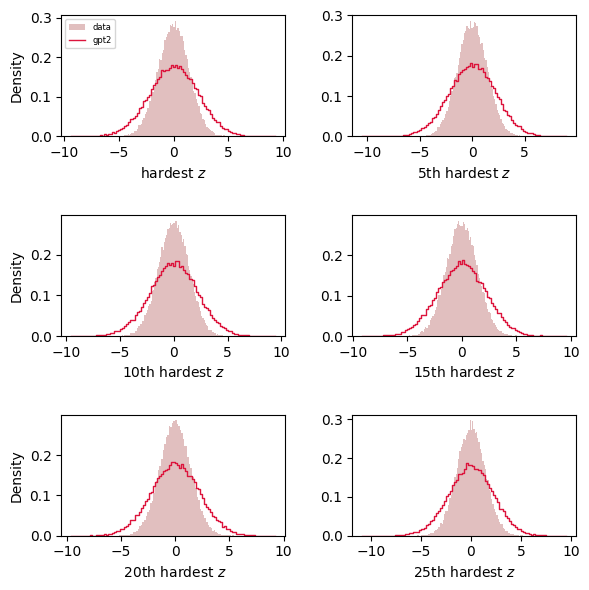

In [ ]:

def ordered_z_plots(toy_qcd, gen_jets, save_file='ordered_z_plots.png', feat=0):

    fig, ax = plt.subplots(3, 2, figsize=(6, 6))

    bins=100

    # --- Plot hardest ---

    sns.histplot(toy_qcd[:,0,:][...,feat], bins=bins, alpha=0.25, color='darkred', lw=0, label='data', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(gen_jets[:,0,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='gpt2', element='step', stat='density', ax=ax[0, 0])

    ax[0,0].set_ylabel('Density')
    ax[0,0].set_xlabel(r'hardest $z$')
    ax[0,0].legend(loc='upper left', fontsize=6)
    # ax[0,0].set_xlim(0, 1)


    sns.histplot(toy_qcd[:,5,:][...,feat], bins=bins,   alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(gen_jets[:,5,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='gpt2', element='step', stat='density', ax=ax[0, 1])
    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel(r'5th hardest $z$')


    # bins=np.arange(0, 0.6, 0.01)

    sns.histplot(toy_qcd[:,10,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(gen_jets[:,10,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 0])

    ax[1,0].set_ylabel('Density')
    ax[1,0].set_xlabel(r'10th hardest $z$')
    # ax[1,0].legend(loc='upper right', fontsize=6)
    # ax[1,0].set_xlim(0, 0.6)

    # bins=np.arange(0, 0.6, 0.008)

    sns.histplot(toy_qcd[:,15,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(gen_jets[:,15,:][...,feat], bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 1])
    ax[1,1].set_ylabel('')
    ax[1,1].set_xlabel(r'15th hardest $z$')
    # ax[1,1].legend(loc='upper right', fontsize=6)
    # ax[1,1].set_xlim(0, 0.6)


    # Middle row: intermediate distributions

    # bins=np.arange(0, 0.2, 0.004)

    sns.histplot(toy_qcd[:,20,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(gen_jets[:,20,:][...,feat], bins=bins, fill=False,  color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 0])

    ax[2,0].set_ylabel('Density')
    ax[2,0].set_xlabel(r' 20th hardest $z$')
    # ax[2,0].legend(loc='upper right', fontsize=6)
    # ax[2,0].set_xlim(0, 0.4)


    # bins=np.arange(0, 0.05, 0.001)

    sns.histplot(toy_qcd[:,25,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(gen_jets[:,25,:][...,feat], bins=bins, fill=False,  color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 1])
    ax[2,1].set_ylabel('')
    ax[2,1].set_xlabel(r'25th hardest $z$')
    # ax[2,1].legend(loc='upper right', fontsize=6)
    # ax[2,1].set_xlim(0, 0.1)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.65, wspace=0.3) 
    plt.savefig(save_file, dpi=300, bbox_inches='tight')

    plt.show()
    
ordered_z_plots(toy_qcd_ord, toy_tops_ord, feat=0)
ordered_z_plots(toy_qcd_ord, toy_tops_ord, feat=1)

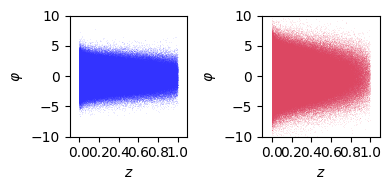

In [ ]:
# plot scatterplot of first vs second feature
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
sns.scatterplot(x=qcd_x, y=qcd_y, color='blue', alpha=0.1, s=0.5, ax=ax[0])
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\varphi$')
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(-10, 10)
ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticks([-10, -5, 0, 5, 10])

sns.scatterplot(x=tops_x, y=tops_y, color='crimson', alpha=0.1, s=0.5, ax=ax[1])
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\varphi$')
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(-10, 10)
ax[1].set_yscale('linear')
ax[1].set_xscale('linear')
ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1].set_yticks([-10, -5, 0, 5, 10])

plt.tight_layout()
plt.show()



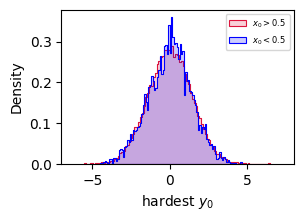

In [ ]:
hardest = toy_qcd_ord[:,0]

plt.figure(figsize=(3,2.))
sns.histplot(hardest[hardest[...,0] > 0.5][...,1], bins=100, color='crimson', alpha=0.2, lw=0.8, label=r'$x_0>0.5$', element='step', stat='density')
sns.histplot(hardest[hardest[...,0] <= 0.5][...,1], bins=100, color='blue', alpha=0.2, lw=0.8, label=r'$x_0<0.5$', element='step', stat='density')
plt.xlabel(r'hardest $y_0$')
plt.xlim(-7, 8)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='upper right', fontsize=6)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()

# Log likelihood computation

In [ ]:
logp_qcd_on_qcd = qcd.log_probs(toy_qcd)
logp_tops_on_tops = tops.log_probs(toy_tops)
logp_qcd_on_tops = qcd.log_probs(toy_tops)
logp_tops_on_qcd = tops.log_probs(toy_qcd)


In [ ]:
LLR_qcd = logp_tops_on_qcd - logp_qcd_on_qcd
LLR_tops = logp_qcd_on_tops - logp_tops_on_tops

from utils import ROC
# LLR_tops_ = np.nan_to_num(LLR_tops, 0)
# LLR_qcd_ = np.nan_to_num(LLR_qcd, 0)

ROC(LLR_qcd, LLR_tops, label='')



plt.figure(figsize=(3,1.))
sns.histplot(LLR_qcd, bins=np.arange(-4,10,0.05), color='crimson', alpha=0.2, lw=0.8, label='S', element='step', stat='density')
sns.histplot(LLR_tops, bins=np.arange(-4,10,0.05), color='blue', alpha=0.2, lw=0.8, label='B', element='step', stat='density')
plt.xlabel(r'log-likelihood ratio')
plt.xlim(-4, 5)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='upper right', fontsize=8)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()

ValueError: zero-dimensional arrays cannot be concatenated